In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import sys

# Connect to MySQL Server

In [2]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="enron",
  database="emails",
  auth_plugin='mysql_native_password'
)

In [3]:
mycursor = mydb.cursor()

# Extract Data to Pandas

mycursor.execute("SELECT * FROM message")

myresult = mycursor.fetchall()

email_df = pd.DataFrame(myresult)

email_df.columns = ['mid','sender','date','message_id','subject','body','folder']

email_df.head(3)

,mid,sender,date,message_id,subject,body,folder
0,52,press.release@enron.com,2000-01-21 04:51:00,<12435833.1075863606729.JavaMail.evans@thyme>,ENRON HOSTS ANNUAL ANALYST CONFERENCE PROVIDES...,HOUSTON - Enron Corp. hosted its annual equity...,Robert_Badeer_Aug2000Notes FoldersPress releases
1,53,office.chairman@enron.com,2000-01-24 01:37:00,<29664079.1075863606676.JavaMail.evans@thyme>,Over $50 -- You made it happen!,"On Wall Street, people are talking about Enron...",Robert_Badeer_Aug2000Notes FoldersPress releases
2,54,office.chairman@enron.com,2000-01-24 02:06:00,<15300605.1075863606629.JavaMail.evans@thyme>,Over $50 -- You made it happen!,"On Wall Street, people are talking about Enron...",Robert_Badeer_Aug2000Notes FoldersPress releases


In [4]:
mycursor.execute("SELECT * FROM employeelist")

myresult = mycursor.fetchall()

employee_df = pd.DataFrame(myresult)

employee_df.columns = ['eid','first_name','last_name','email_id']

employee_df.head(3)

mycursor.execute("SELECT * FROM recipientinfo")

myresult = mycursor.fetchall()

recipient_df = pd.DataFrame(myresult)

recipient_df.columns = ['rid','mid','r_type','r_value','date_r']

recipient_df.head(3)

,rid,mid,r_type,r_value,date_r
0,67,52,TO,all.worldwide@enron.com,None
1,68,53,TO,all.downtown@enron.com,None
2,69,54,TO,all.enron-worldwide@enron.com,None


In [5]:
mycursor.execute("SELECT * FROM referenceinfo")

myresult = mycursor.fetchall()

reference_df = pd.DataFrame(myresult)

reference_df.columns = ['rfid','mid','reference']

reference_df.head(3)

# Data Frame Characteristics

,rfid,mid,reference
0,2,79,"> From: Le Vine, Debi> Sent: Thursday, August ..."
1,3,99,"> From: Golden, Mark> Sent: Thursday, August 2..."
2,8,533,"From: Sole, JeanneSent: Friday, August 18, 200..."


In [6]:
len(set(recipient_df['r_value']))

68224

In [7]:
len(reference_df)

54778

In [8]:
len(set(email_df['folder']))

3893

# Create Dataframe of email records with sender and reciever information

In [9]:
# create mapping of messages to lists of recipients and how many recipients that email has
mid_dict = {}
count =0
total = len(recipient_df)
for mid,r_value in zip(recipient_df['mid'],recipient_df['r_value']) :
    if mid in mid_dict.keys():
        mid_dict[mid].append(r_value)
    else:
        mid_dict[mid] = [r_value]

In [10]:
#unique message IDs, hopefully the same as len(email_df)
len(mid_dict)

252759

# count how many emails a particular user sends and  recieves

sender_total_dict = {}
for sender in email_df['sender']:
    if sender in sender_total_dict:
        sender_total_dict[sender] += 1
    else:
        sender_total_dict[sender] = 1

recer_total_dict = {}
for recer in recipient_df['r_value']:
    if recer in recer_total_dict:
        recer_total_dict[recer] += 1
    else:
        recer_total_dict[recer] = 1

(0, 5000)

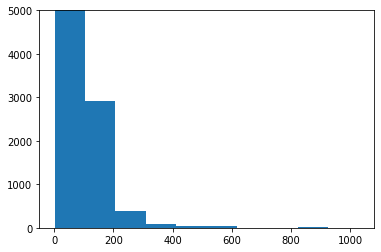

In [11]:
network_df = pd.DataFrame()

network_df['mid'] = list(set(recipient_df['mid']))


lst = []
lst_num = []
for mid in network_df['mid']:
    lst.append(mid_dict[mid])
    lst_num.append(len(mid_dict[mid]))
network_df['rec_list'] = lst
network_df['rec_count'] = lst_num


plt.hist(network_df['rec_count'])
plt.ylim(0,5000)

In [12]:
network_df = network_df.merge(email_df[['mid','sender','date']])

network_df.head()

,mid,rec_list,rec_count,sender,date
0,52,[all.worldwide@enron.com],1,press.release@enron.com,2000-01-21 04:51:00
1,53,[all.downtown@enron.com],1,office.chairman@enron.com,2000-01-24 01:37:00
2,54,[all.enron-worldwide@enron.com],1,office.chairman@enron.com,2000-01-24 02:06:00
3,55,[all.worldwide@enron.com],1,press.release@enron.com,2000-02-02 10:21:00
4,56,"[all_enron_north.america@enron.com, ec.communi...",2,office.chairman@enron.com,2000-02-07 22:16:00


In [13]:
# add metric of how many emails the message sender has sent

# Create Mapping of users to IDs that includes all known users

In [14]:
main_emails = list(employee_df['email_id'])
len(main_emails)

151

In [15]:
all_users = list(set(network_df['sender']))

all_users =  all_users + list(recipient_df['r_value'])

all_users = list(set(all_users))

len(all_users)

75557

In [16]:
email_to_id = {}
id_to_email ={}
count = 0
for user in all_users:
    email_to_id[user] = count
    id_to_email[count] = user
    count+=1

In [17]:
#[sender in main_emails for sender in email_df['sender']]

In [18]:
# How many of the emails in the corpus originate from the main users
sum([(sender in main_emails) for sender in network_df['sender']])

87120

In [19]:
user_matrix = np.zeros((len(all_users),len(all_users)))

In [20]:
for sender ,rec_list,rec_count in zip(network_df['sender'],network_df['rec_list'],network_df['rec_count']):
    for recer in rec_list:
        user_matrix[email_to_id[sender]][email_to_id[recer]] += (1/rec_count)
        user_matrix[email_to_id[recer]][email_to_id[sender]] += (1/rec_count)

In [21]:
len(network_df)

252759

In [22]:
user_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
len(user_matrix)

75557

In [24]:
user_totals = sum(user_matrix)

In [25]:
sum(user_totals)

505518.00000002206

In [26]:
# Set Signifigance Threshhold to be in graph

In [27]:
sig_thresh = np.percentile(user_totals,99.83)

In [28]:
sig_thresh

510.69194316524573

In [29]:
count = 0
sig_ids = []
for total in user_totals:
    if count == email_to_id['jeff.skilling@enron.com']:
        sig_ids.append(count)
    if total>sig_thresh:
        sig_ids.append(count)
    count+=1

In [30]:
len(sig_ids)

130

In [31]:
# find Jeffrey Skilling in Data at jeff.skilling@enron.com
employee_df[employee_df['first_name'] =='Jeffrey']

,eid,first_name,last_name,email_id
36,36,Jeffrey,Shankman,a..shankman@enron.com
129,129,Jeffrey,Skilling,jeff.skilling@enron.com


# Jeffery Skilling Check

In [32]:
email_to_id['jeff.skilling@enron.com'] in sig_ids

True

In [33]:
sum([email_to_id[email] in sig_ids for email in employee_df['email_id'] ])

73

In [34]:
sig_users = [id_to_email[eid] for eid in sig_ids]


# Create Sig Users Network


In [35]:
len(sig_users)

130

In [36]:
sig_users

['kam.keiser@enron.com',
 'marketing@nymex.com',
 'sally.beck@enron.com',
 'maureen.mcvicker@enron.com',
 'larry.campbell@enron.com',
 'cara.semperger@enron.com',
 'd..steffes@enron.com',
 'mike.mcconnell@enron.com',
 'michelle.cash@enron.com',
 'vkaminski@aol.com',
 'rod.hayslett@enron.com',
 'steven.harris@enron.com',
 'david.forster@enron.com',
 'darrell.schoolcraft@enron.com',
 'benjamin.rogers@enron.com',
 'leslie.hansen@enron.com',
 'gerald.nemec@enron.com',
 'elizabeth.sager@enron.com',
 'j..kean@enron.com',
 'alan.aronowitz@enron.com',
 'susan.bailey@enron.com',
 'rick.buy@enron.com',
 'robin.rodrigue@enron.com',
 'tim.belden@enron.com',
 'jdasovic@enron.com',
 'david.oxley@enron.com',
 'shirley.crenshaw@enron.com',
 ' All Enron Houston@ENRON',
 'm..scott@enron.com',
 'alan.comnes@enron.com',
 'all.houston@enron.com',
 'david.delainey@enron.com',
 'michelle.lokay@enron.com',
 'stephanie.panus@enron.com',
 'mark.taylor@enron.com',
 'jae.black@enron.com',
 'brent.hendry@enron.com

In [37]:
sig_email_to_id = {}
sig_id_to_email ={}
count = 0
for user in sig_users:
    sig_email_to_id[user] = count
    sig_id_to_email[count] = user
    if user == 'jeff.skilling@enron.com':
        print('Jeffs ID is ',count)
    count+=1

Jeffs ID is  63
Jeffs ID is  64


In [38]:
sig_user_matrix = np.zeros((len(sig_users),len(sig_users)))

In [39]:
for sender,rec_list,rec_count in zip(network_df['sender'],network_df['rec_list'],network_df['rec_count']):
    for rec in rec_list:
        if sender in sig_users and rec in sig_users:
            sig_user_matrix[sig_email_to_id[sender]][sig_email_to_id[rec]] += 1/rec_count
            sig_user_matrix[sig_email_to_id[rec]][sig_email_to_id[sender]] += 1/rec_count

In [40]:
sum(sum(sig_user_matrix))

69076.99248411432

In [41]:
sig_user_matrix

array([[  4.21271397,   0.        ,   1.35502354, ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , 532.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  1.35502354,   0.        ,  13.19220881, ...,   0.        ,
          1.25178319,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   6.0287035 ,
          0.        ,  43.1847173 ],
       [  0.        ,   0.        ,   1.25178319, ...,   0.        ,
          0.        ,   0.87777778],
       [  0.        ,   0.        ,   0.        , ...,  43.1847173 ,
          0.87777778,   1.78626263]])

In [42]:
sig_user_matrix.shape

(130, 130)

In [43]:
#sig_user_matrix[sig_user_matrix>0]=1

In [44]:
sig_user_matrix

array([[  4.21271397,   0.        ,   1.35502354, ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , 532.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  1.35502354,   0.        ,  13.19220881, ...,   0.        ,
          1.25178319,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   6.0287035 ,
          0.        ,  43.1847173 ],
       [  0.        ,   0.        ,   1.25178319, ...,   0.        ,
          0.        ,   0.87777778],
       [  0.        ,   0.        ,   0.        , ...,  43.1847173 ,
          0.87777778,   1.78626263]])

# Network Vizualization

In [45]:
import plotly.graph_objects as go

import networkx as nx

## create list of edge values to compute percentiles for pruning

In [70]:

edge_values = list(sig_user_matrix)
l =[]
for edges in edge_values:
    l = l + list(edges)
edge_values = l

## ## Save Jeffery Skilling id to find isolated nodes in the network

In [71]:
jeff_sig_id = sig_email_to_id['jeff.skilling@enron.com']

In [72]:
#check Jeff ConnectedNess above threshold
sum(sig_user_matrix[jeff_sig_id]>8)

2

# Create and Prune edges of Network Graph to vizualize

In [102]:
G = nx.Graph()

In [103]:
G.add_nodes_from(range(len(sig_user_matrix)))

In [104]:
edge_thresh = np.percentile(edge_values,90)
for i in range(len(sig_user_matrix)):
    for j in range(len(sig_user_matrix)):
        #if i ==jeff_sig_id:
                #print('jeff_potential')
        if sig_user_matrix[i][j] > edge_thresh:
            if i ==jeff_sig_id:
                print('jeff_connection')
            G.add_edge(i,j)

jeff_connection
jeff_connection
jeff_connection
jeff_connection
jeff_connection
jeff_connection
jeff_connection
jeff_connection
jeff_connection


In [105]:
np.percentile(sig_user_matrix,95)

9.492460317460315

In [106]:
### Check Jeff Neighbors

In [107]:
jeff_sig_id

64

## Remove Nodes that do not connect signifigantly to Jeffery


In [108]:
jeff_dist_dict = list((nx.all_pairs_shortest_path_length(G)))[jeff_sig_id][1]
len(jeff_dist_dict)

125

In [109]:
jeff_dist_dict

{64: 0,
 2: 1,
 7: 1,
 31: 1,
 53: 1,
 93: 1,
 110: 1,
 112: 1,
 114: 1,
 122: 1,
 8: 2,
 10: 2,
 12: 2,
 18: 2,
 21: 2,
 23: 2,
 25: 2,
 47: 2,
 62: 2,
 65: 2,
 78: 2,
 79: 2,
 84: 2,
 118: 2,
 123: 2,
 126: 2,
 19: 2,
 59: 2,
 128: 2,
 3: 2,
 14: 2,
 38: 2,
 40: 2,
 46: 2,
 61: 2,
 76: 2,
 91: 2,
 99: 2,
 100: 2,
 108: 2,
 6: 2,
 29: 2,
 101: 2,
 120: 2,
 127: 2,
 129: 2,
 57: 2,
 117: 2,
 48: 2,
 66: 2,
 102: 2,
 106: 2,
 11: 2,
 24: 2,
 32: 2,
 39: 2,
 90: 2,
 92: 2,
 15: 3,
 17: 3,
 34: 3,
 68: 3,
 124: 3,
 55: 3,
 58: 3,
 60: 3,
 35: 3,
 88: 3,
 103: 3,
 115: 3,
 5: 3,
 52: 3,
 119: 3,
 0: 3,
 50: 3,
 4: 3,
 16: 3,
 26: 3,
 27: 3,
 28: 3,
 33: 3,
 36: 3,
 41: 3,
 42: 3,
 44: 3,
 45: 3,
 49: 3,
 51: 3,
 67: 3,
 70: 3,
 71: 3,
 73: 3,
 74: 3,
 75: 3,
 77: 3,
 81: 3,
 82: 3,
 83: 3,
 87: 3,
 96: 3,
 104: 3,
 121: 3,
 107: 3,
 9: 3,
 69: 3,
 37: 3,
 43: 3,
 20: 3,
 105: 3,
 109: 3,
 80: 3,
 86: 3,
 54: 3,
 13: 3,
 22: 3,
 72: 4,
 97: 4,
 116: 4,
 125: 4,
 56: 4,
 95: 4,
 98: 4,
 94: 

In [110]:
for i in range(len(sig_ids)):
    if i not in jeff_dist_dict:
        G.remove_node(i)
        
#Jeff Check
email_to_id['jeff.skilling@enron.com'] in list(G.nodes())

False

In [95]:
sig_id_to_email[jeff_sig_id]

'jeff.skilling@enron.com'

In [96]:
#Removing node disconected Nodes
#remove = [node for node,degree in dict(G.degree()).items() if degree < 2]
#G.remove_nodes_from(remove)

In [97]:
G.remove_nodes_from(list(nx.isolates(G)))

# attempt to animate Spring Graph

In [98]:
from IPython.display import HTML
from matplotlib import pyplot as plt
from celluloid import Camera

//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



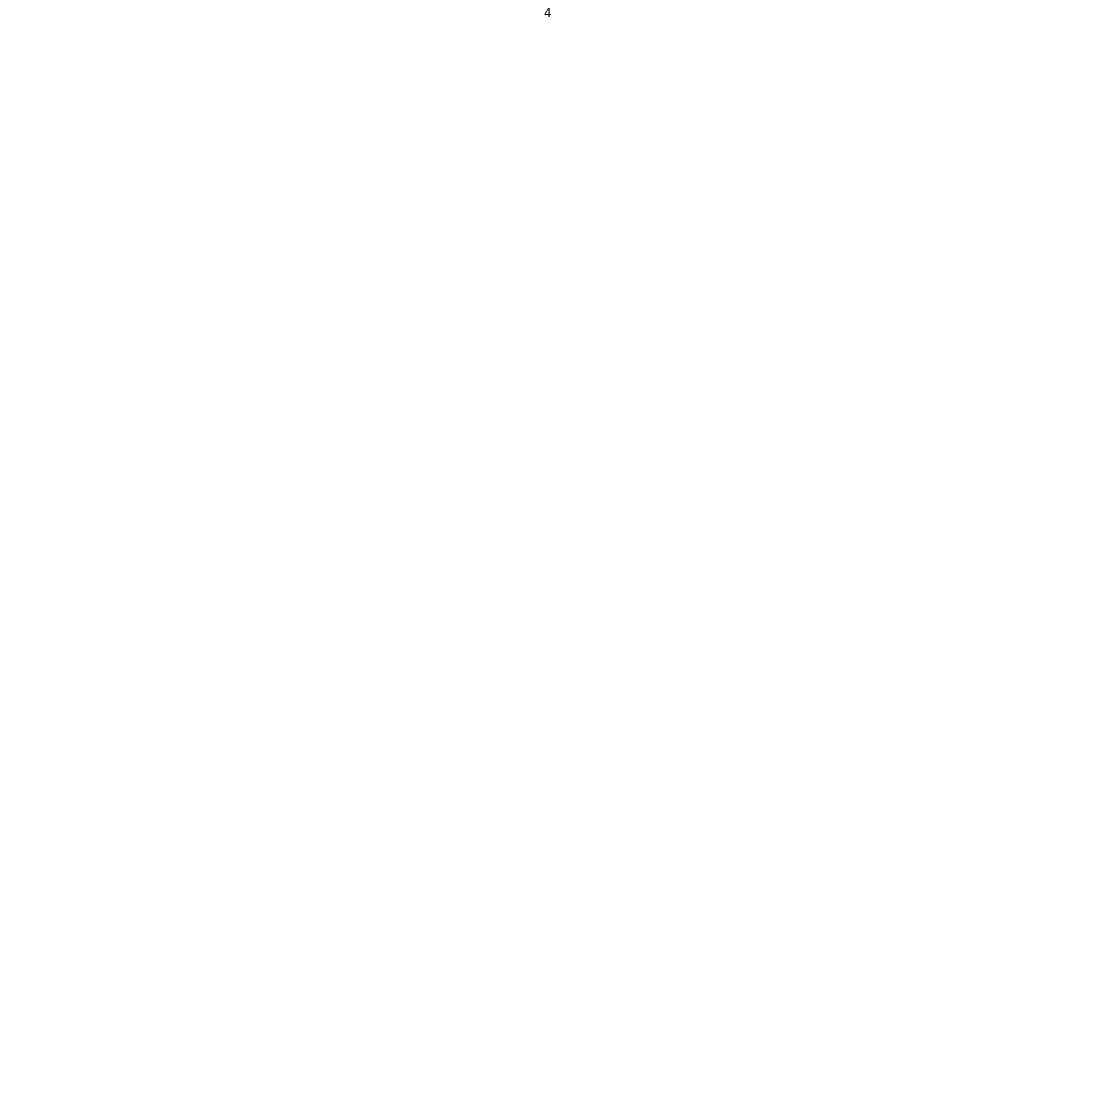

In [99]:
fig = plt.figure(figsize=(15,15))
camera = Camera(fig)
for i in range(5):
    pos = nx.spring_layout(G,iterations=i)
    
    nx.draw(G,pos,node_size=30,k=.2)
    plt.title(i)
    
    camera.snap()
animation = camera.animate(interval=500)
animation.save('celluloid_minimal.gif', writer = 'imagemagick')
#HTML(animation.to_jshtml())

# Animate Shells Layout

In [100]:
jeff_sig_id

64

In [64]:
jeff_groups = []
for i in range(10):
    i_range_list = []
    for key,value in jeff_dist_dict.items():
        if jeff_dist_dict[key] ==i:
            i_range_list.append(key)
    jeff_groups.append(i_range_list)
            

In [65]:
while [] in jeff_groups:
    jeff_groups.remove([])
len(jeff_dist_dict)

1

In [66]:
color_palette = ['r','g','b','c','m','y','k','k']
size_palette = [1200,900,400,200,100,100,100,100,100,100]
jeff_colors = []
jeff_size = []

for node_num in list(G.nodes()):
    jeff_colors.append(color_palette[jeff_dist_dict[node_num]])
    jeff_size.append(float(size_palette[jeff_dist_dict[node_num]]))

In [67]:
def draw_shells():
    
    pos = nx.shell_layout(G,nlist=jeff_groups)
    # larger figure size
    plt.figure(3,figsize=(10,10)) 
    nx.draw(G,pos,node_size=60)
    plt.title('Shell Network Based on Jeff Proximity')


<Figure size 1080x1080 with 0 Axes>

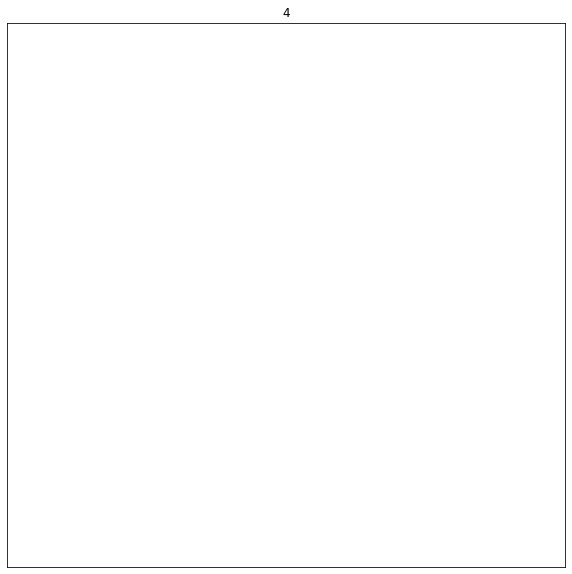

In [68]:
fig = plt.figure(figsize=(15,15))
camera = Camera(fig)
for i in range(5):
    pos = nx.spring_layout(G,iterations=i)
    
    pos = nx.shell_layout(G)
    # larger figure size
    plt.figure(3,figsize=(10,10)) 
    nx.draw_networkx(G,pos,node_size=300)
    plt.title('Shell Network Based on Jeff Proximity')
    plt.title(i)
    
    camera.snap()
animation = camera.animate(interval=500)
animation.save('celluloid_minimal.gif', writer = 'imagemagick')

In [69]:
fig = plt.figure(figsize=(15,15))
camera = Camera(fig)
for i in range(50):

    shell_pos = nx.shell_layout(G,nlist=jeff_groups)
    pos = nx.spring_layout(G,iterations=i,pos=shell_pos,k=.1)
        # larger figure size
    nx.draw_networkx_nodes(G,pos,node_size=jeff_size,node_color=jeff_colors_plotly,)
    plt.title('Shell Network Based on Jeff Proximity')
    camera.snap()
    
animation = camera.animate(interval=200)
animation.save('Spring_Proximity_Jeff.gif', writer = 'imagemagick')
HTML(animation.to_jshtml())

ValueError: max() arg is an empty sequence

<Figure size 1080x1080 with 0 Axes>

## Attempting Plotly Integration

In [ ]:
plotly_color = ['red','orange','yellow','purple','green','black','black']


jeff_colors_plotly = []


for node_num in list(G.nodes()):
    jeff_colors_plotly.append(plotly_color[jeff_dist_dict[node_num]])

In [ ]:
pos = nx.random_layout(G)
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)


In [ ]:
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

In [ ]:
node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

In [ ]:
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [ ]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))


for node in G.nodes():
    node_text.append(sig_id_to_email[node])

node_trace.marker.color = jeff_colors_plotly
node_trace.text = node_text

In [ ]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()

In [ ]:
pos[jeff_sig_id]